In [2]:
from pyomo.environ import *

In [3]:
m = AbstractModel()
m.N_value = Param(domain=PositiveIntegers)
m.W_max = Param(domain=PositiveReals)
m.H_max = Param(domain=PositiveReals)
m.N = RangeSet(m.N_value)
m.N_N = Set(initialize=m.N*m.N, filter=lambda _,i,j: i<j)

m.H = Param(m.N, domain=PositiveReals)
m.W = Param(m.N, domain=PositiveReals)
#m.max_HW = Param(initialize=max([m.H_max, m.W_max]))

m.H_rot = Var(m.N, domain=PositiveReals, bounds=(0, m.H_max*m.W_max))
m.W_rot = Var(m.N, domain=PositiveReals, bounds=(0, m.H_max*m.W_max))

m.x = Var(m.N, domain=NonNegativeReals, bounds=(0,m.W_max), initialize=0)
m.y = Var(m.N, domain=NonNegativeReals, bounds=(0,m.H_max), initialize=0)
m.lt = Var(domain=PositiveReals)
m.obj = Objective(expr=m.lt)

@m.Constraint(m.N)
def height_constr(m,i):
    return m.y[i]+m.H_rot[i] <= m.H_max

@m.Constraint(m.N)
def objective_constr(m,i):
    return m.x[i]+m.W_rot[i] <= m.lt

@m.Disjunction(m.N_N)
def direction_disjunct(m,i,j):
    return [
        m.x[i]+m.W_rot[i] <= m.x[j],
        m.x[j]+m.W_rot[j] <= m.x[i],
        m.y[i]+m.H_rot[i] <= m.y[j],
        m.y[j]+m.H_rot[j] <= m.y[i]
    ]

@m.Disjunction(m.N)
def rotation(m,i):
    return [[m.W_rot[i] == m.W[i], m.H_rot[i] == m.H[i]],
            [m.W_rot[i] == m.H[i], m.H_rot[i] == m.W[i]]]

In [4]:
instance = m.create_instance('rand_params_2D.dat')
opt = SolverFactory('gdpopt')
opt.solve(instance);

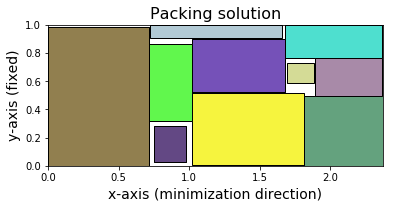

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(1)
plt.xlim((0,max([instance.x[i].value+instance.W_rot[i].value for i in instance.N])))
plt.ylim((0,instance.H_max.value))
ax.set_aspect('equal')
plt.title('Packing solution', fontsize=16)
plt.xlabel('x-axis (minimization direction)', fontsize=14)
plt.ylabel('y-axis (fixed)', fontsize=14)

for i in instance.N:
    r_border = Rectangle(
        (instance.x[i].value,instance.y[i].value),
        instance.W_rot[i].value,instance.H_rot[i].value,
        color='black',fill=False)
    random.seed(i)
    random_color = [random.random() for i in range(3)]
    r_fill = Rectangle(
        (instance.x[i].value,instance.y[i].value),
        instance.W_rot[i].value,instance.H_rot[i].value,
        color=random_color, alpha=0.8)
    ax.add_patch(r_fill)
    ax.add_patch(r_border)
plt.savefig('figs/2D-single-rotation.png')

In [27]:
[instance.y[i].value for i in instance.N]

[0.041894749960024374,
 None,
 0.011123559346005101,
 0.1582823199298794,
 0.424394848546794]